# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [32]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from fastprogress import progress_bar

In [34]:
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [35]:
from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.plotFunctions import *
from utilities.MonitorBDD import MonitorBDD
from utilities.pcaFunctions import numComponents

In [36]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

### Setup Variables

In [341]:
# DATASET = 'MNIST'
# DATASET = 'FashionMNIST'
DATASET = 'GTSRB'


# print available models
model_names = get_models(base, DATASET)
for i, m in enumerate(model_names):
    print(i, m)

0 AdamW-32-30
1 AdamW-32-50
2 AdamW-32-80
3 AdamW-32-150


In [342]:
POSTFIX = model_names[1]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

FILENAME_POSTFIX

'GTSRB_AdamW-32-50'

# Paths

In [343]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

configs = load_json(paths['configuration'])
config = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']
optim_name = list(config['optimizer'].keys())[0]
optim_args = config['optimizer'][optim_name]
scheduler_name = list(config['scheduler'].keys())[0]
scheduler_args = config['scheduler'][scheduler_name]

# Model

In [41]:
SEED = 0
CUDA = 0

LHL = int(POSTFIX.split('-')[-1])
GPU_NAME = f'cuda:{CUDA}'

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [42]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [43]:
# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model.name

'GTSRB_AdamW-32-50-acc-0.963-loss-0.129.pth.tar'

In [44]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = LHL
model = model_(**model_setup).to(device)
model = torch.compile(model)
# nn.DataParallel(model, device_ids=[CUDA])

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

OptimizedModule(
  (_orig_mod): GTSRB_CNN(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (scaleInputs): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Sequential(
      (0): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Conv2d(256, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(64, 64, kernel_size=(2, 2

In [297]:
idx_filename = base / 'experiments' / 'GTSRB_idx.csv'
if not idx_filename.is_file(): idx_filename.touch()
np.savetxt(idx_filename, idx.to_numpy(), delimiter=',', fmt='%d')

In [299]:
(np.loadtxt(idx_filename, dtype='int')

True

In [45]:
feature_names = get_labels(DATASET)

test_data = get_dataset(DATASET, path_data, train=False)

if DATASET == "GTSRB":
    idx_filename = base / 'experiments' / 'GTSRB_idx.csv'
    if not idx_filename.is_file():
        idx_filename.touch()
        _, idx = train_test_split(test_data.data.index, stratify=test_data.data[0], test_size=43*5)
        np.savetxt(idx_filename, idx.to_numpy(), delimiter=',', fmt='%d')
    else:
        idx = np.loadtxt(idx_filename, dtype='int'
        
else:
    _, idx = train_test_split(test_data.targets.numpy(), stratify=test_data.targets.numpy(), test_size=10*5)


test_data_norm = get_dataset(DATASET, path_data, train=False, transform=transformer['test'])
test_data_norm.data = test_data_norm.data.loc[idx]
testloader = get_dataLoader(test_data_norm, len(idx), False)

# Model Inference

In [49]:
for x,y in testloader:
    y_pred = model(x.to(device))
    y_pred = y.to(device) == y_pred.argmax(dim=1)
    y_pred = y_pred.cpu().numpy()

# Gaussian Noise

In [62]:
class AddGaussianNoise():
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        tensor = tensor + torch.randn(tensor.size()) * self.std + self.mean
        if tensor.size()[0] > 1:
            return torch.clamp(tensor / 255, 0, 1)
        else:
            return torch.clamp(tensor, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Import Data

In [345]:
# import Data
flavor = 'raw'
# flavor = 'pca'

if flavor=='raw': path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_train.csv")
df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_test.csv")
df_eval = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_evaluation.csv")

# select only true classified
# df_true = df_train.copy()
df_true = pd.concat([df_train[df_train["true"] == True].copy(), df_test[df_test["true"] == True].copy()])
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

# df_true = df_train[df_train["true"] == True].copy()
# df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_train.shape, df_test.shape, df_eval.shape, df_true.shape 

((63968, 52), (4192, 52), (1000, 52), (65661, 51))

In [346]:
gte_mean = load_json(path_lhl.parent / "neurons_gte_mean.json")
top_third = load_json(path_lhl.parent / "neurons_top_third.json")

In [347]:
pca = load_pickle(path_lhl.parent / "pca.pkl")

# Build BDD

In [348]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0

neurons = []
neurons = gte_mean
# neurons = top_third
# if flavor=='pca':
#     nerons = [f'x{i}' for i in range(numComponents(pca))]
#     subset_name = 'components'

# calculate threshold
if thld_p == 0:
    thld = np.zeros(df_true.drop('y', axis=1).shape[1])
else: thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)

# thld = np.mean( df_true.drop('y', axis=1), axis=0)

st = time.perf_counter()

# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons, reorder=False, memory=10)
df_train_copy, df_test_copy, df_eval_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy(), df_eval.copy()] )

en = round(int(time.perf_counter() - st) / 60, 3)

# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
df_eval_scores = patterns.score_dataframe_multi_eta(df_eval_copy, eta)

# add metadata
patterns.stats['num_observations'] = df_true.shape[0]

en

0.1

In [349]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,NaN,0.0,0.017,147.1,0.0,65661.0,40.6,0.0,25.0,2023-09-18 21:53:29,2023-09-18 21:53:31,65661


In [350]:
df_train_scores.loc[ df_train_scores['y'] == 'all']

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
43,all,63968.0,2345.0,2101.0,2101.0,0.0,0.032845,1.0,0.895949,0,None,25.0


In [351]:
df_test_scores.loc[ df_test_scores['y'] == 'all']

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
43,all,4192.0,154.0,139.0,139.0,0.0,0.033158,1.0,0.902597,0,None,25.0


In [352]:
df_eval_scores.loc[ df_eval_scores['y'] == 'all' ]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
1,all,1000.0,0.0,977.0,0.0,977.0,0.977,0.0,0.0,0,None,25.0


In [224]:
# file_name = f'qth_{thld_p}-{FILENAME_POSTFIX}'

# patterns.stats.to_csv(path_bdd / f'info-{file_name}_train.csv', index=False)
# df_train_scores.to_csv(path_bdd / f'scores-{file_name}_train.csv', index=False)
# df_test_scores.to_csv(path_bdd / f'scores-{file_name}_test.csv', index=False)
# df_eval_scores.to_csv(path_bdd / f'scores-{file_name}_evaluation.csv', index=False)

# Noisy Images

In [212]:
misclassified = np.where(y_pred == False)[0]
misclassified

array([ 20,  36,  44, 154, 204])

In [225]:
def show_image(id_):
    plt.close('all')

    if DATASET == "GTSRB":
        im = torch.tensor(plt.imread(test_data.root / test_data.data[1][idx[id_]])).permute(2, 0, 1)
    else:
        im = test_data[idx[id_]][0]

    if DATASET == 'GTSRB':
        n = 5
        ns = 5
    else:
        n = 5
        ns = 0.05

    noises = np.zeros(6)
    noises[1:] = np.cumprod([ns, 2, 2, 2, 2])

    test_data_noise = [AddGaussianNoise(0, noises[i])(im) for i in range(n+1)]

    x = transformer['test'].transforms[1](torch.stack(test_data_noise))

    logits, pred = model.output_last_layer(x.to(device))
    logits = logits.cpu().numpy()
    pred = pred.argmax(axis=1).cpu().numpy()
    logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])

    logits['y'] = test_data.data[0][idx[id_]]
    logits['true'] = pred == test_data.data[0][idx[id_]]

    logits_copy = logits.copy()
    patterns.evaluate_dataframe(logits_copy, 0)

    fig, ax = plt.subplots(1, n+1, figsize=(n*5, 5))

    for i,(m,a,g) in enumerate(zip(test_data_noise, ax, noises)):
        a.imshow(m.permute(1, 2, 0))
        a.set_title(f"STD={int(g)}, P={logits_copy['true'][i]}, BDD={logits_copy['bdd_0'][i]}", fontsize=16)
        a.axis(False)

    fig.suptitle(f"Label: {feature_names[test_data.data[0][idx[id_]]]}, Index: {idx[id_]}", fontsize=24)
    plt.show()

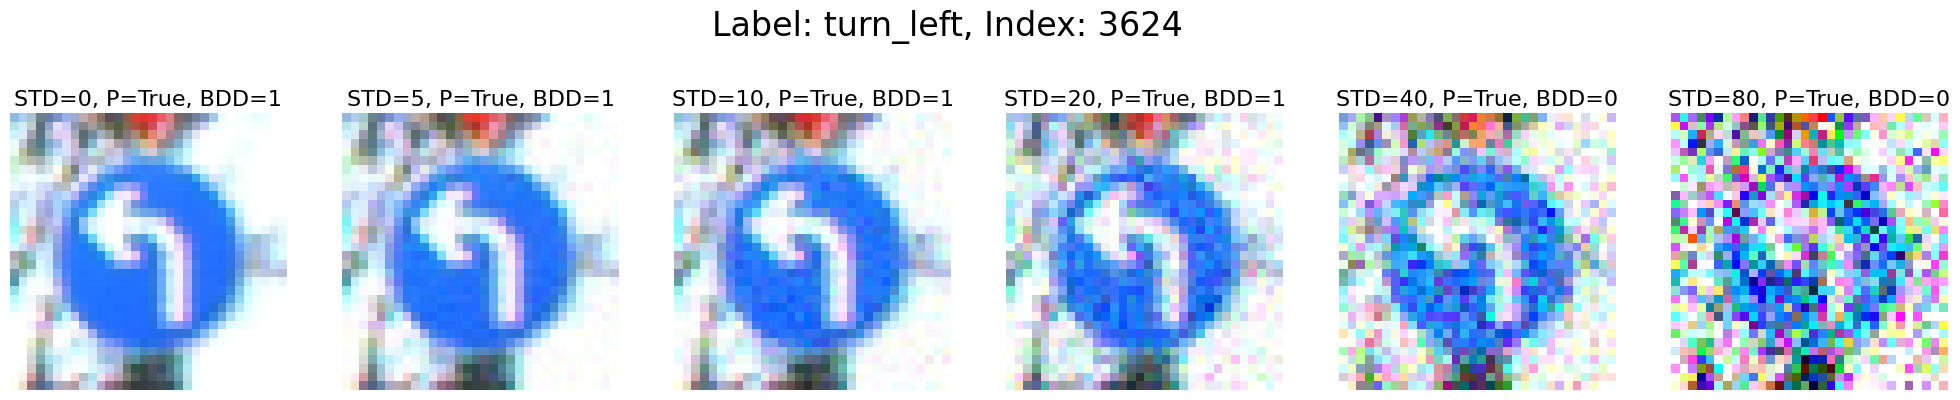

In [226]:
show_image(3)

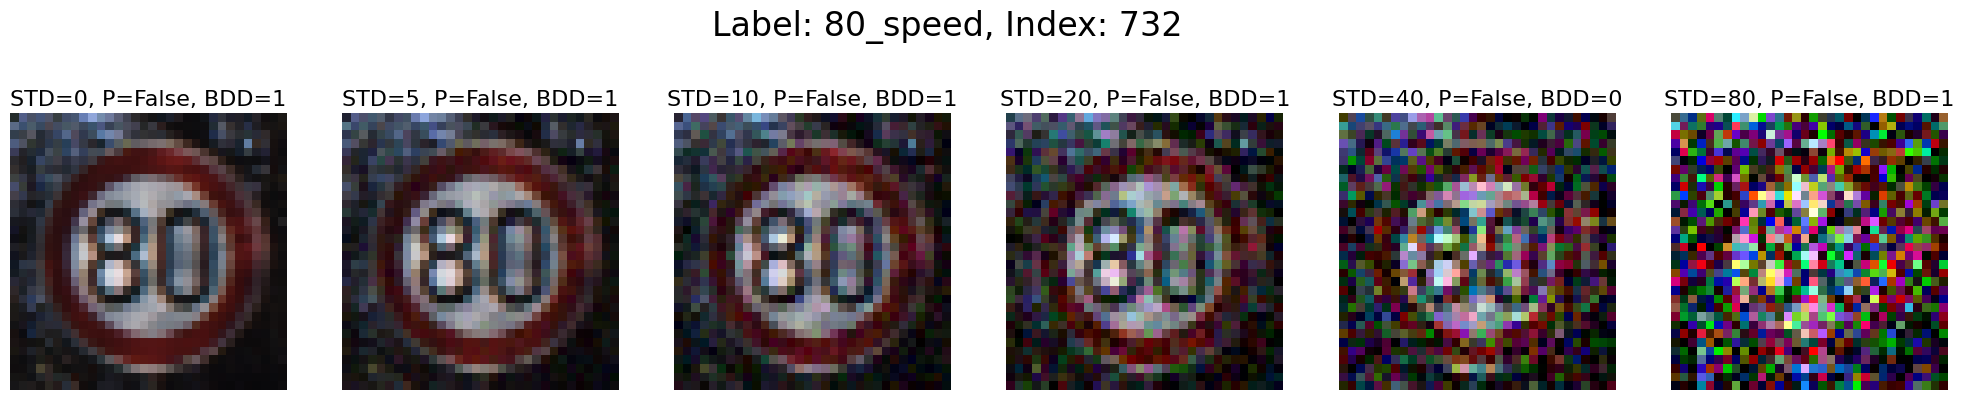

In [229]:
show_image(36)

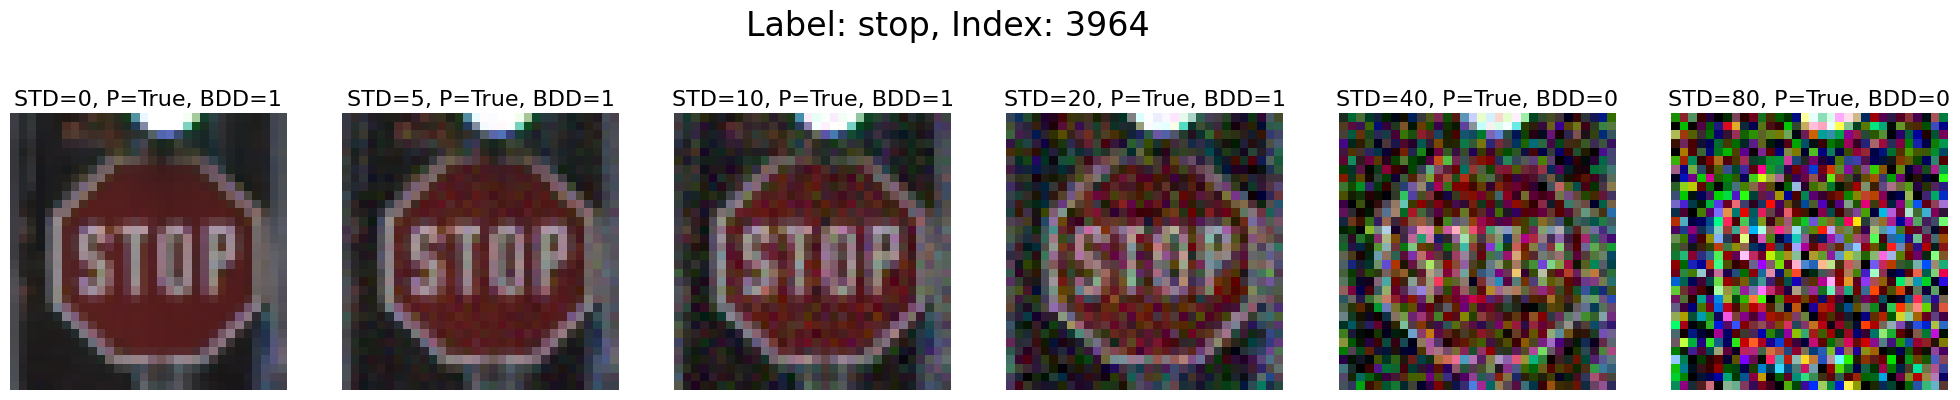

In [228]:
show_image(103)

# Extra Examples

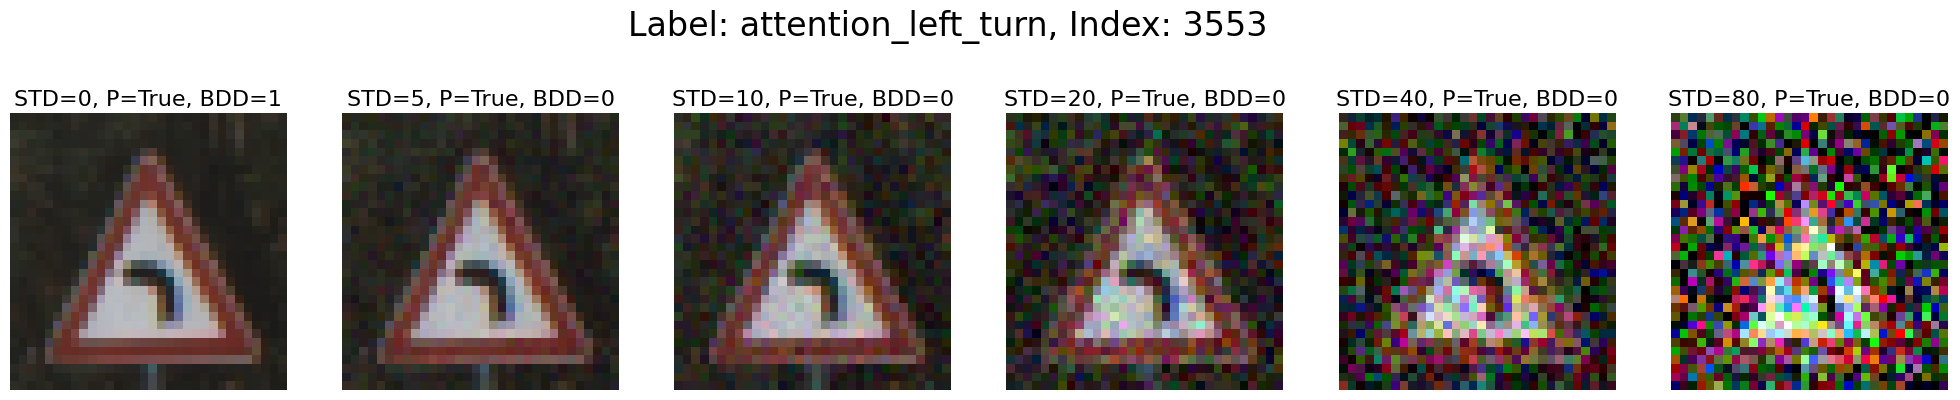

In [143]:
show_image(80)

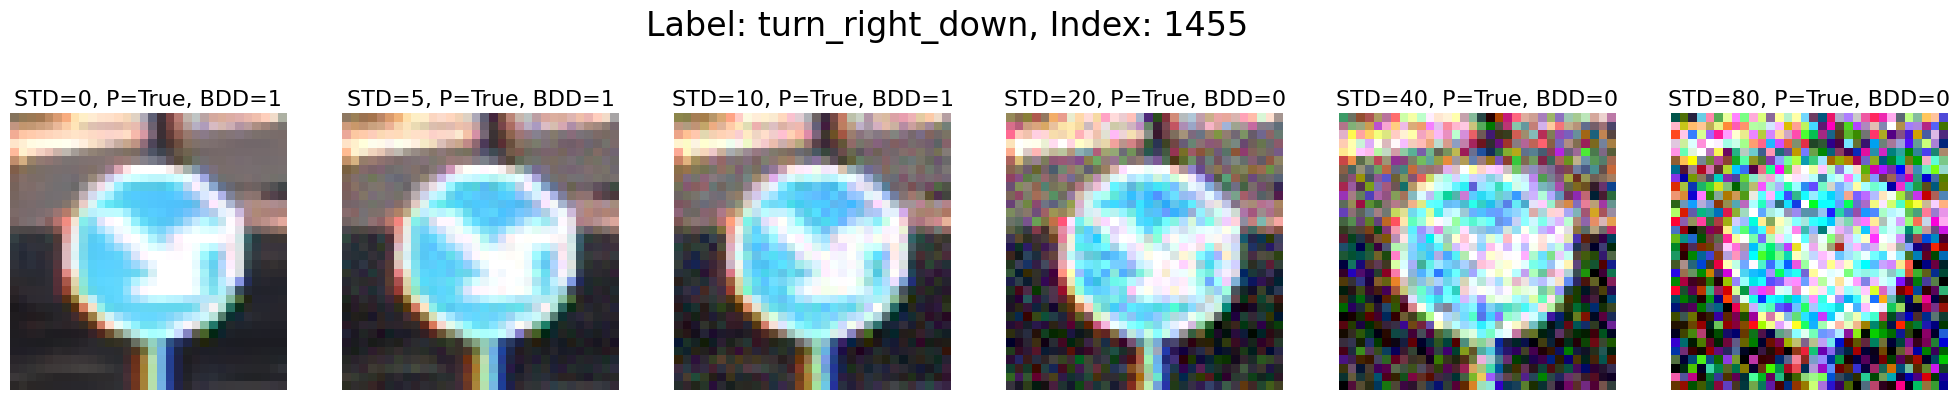

In [144]:
show_image(1)

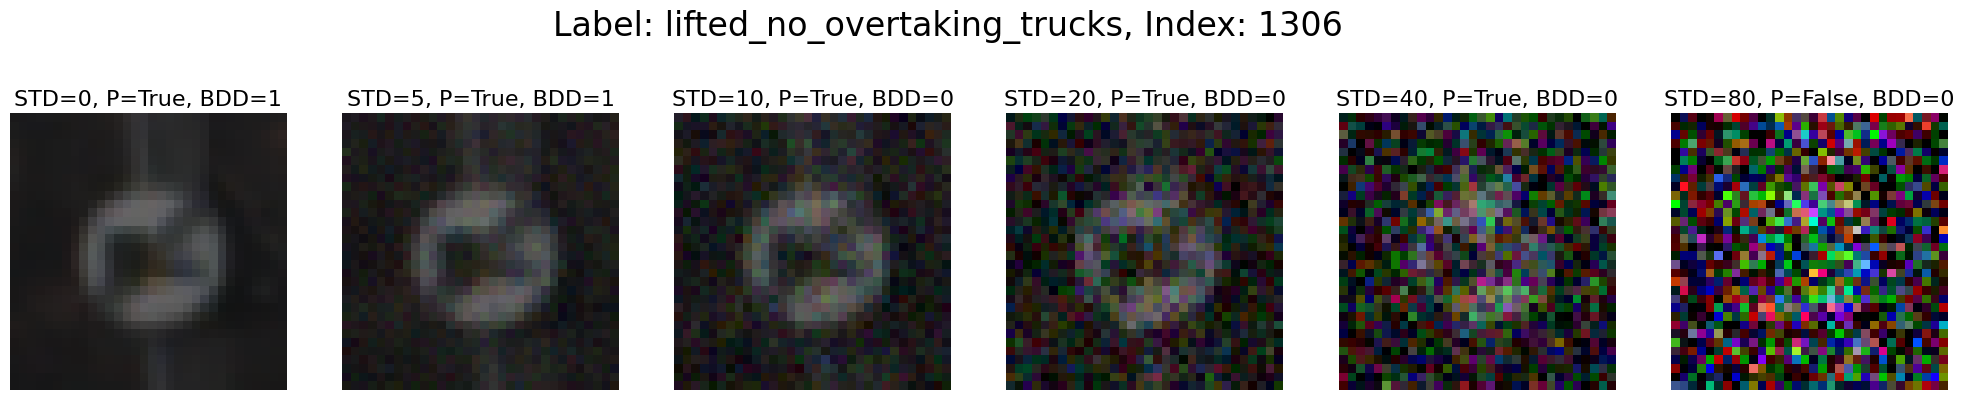

In [145]:
show_image(82)

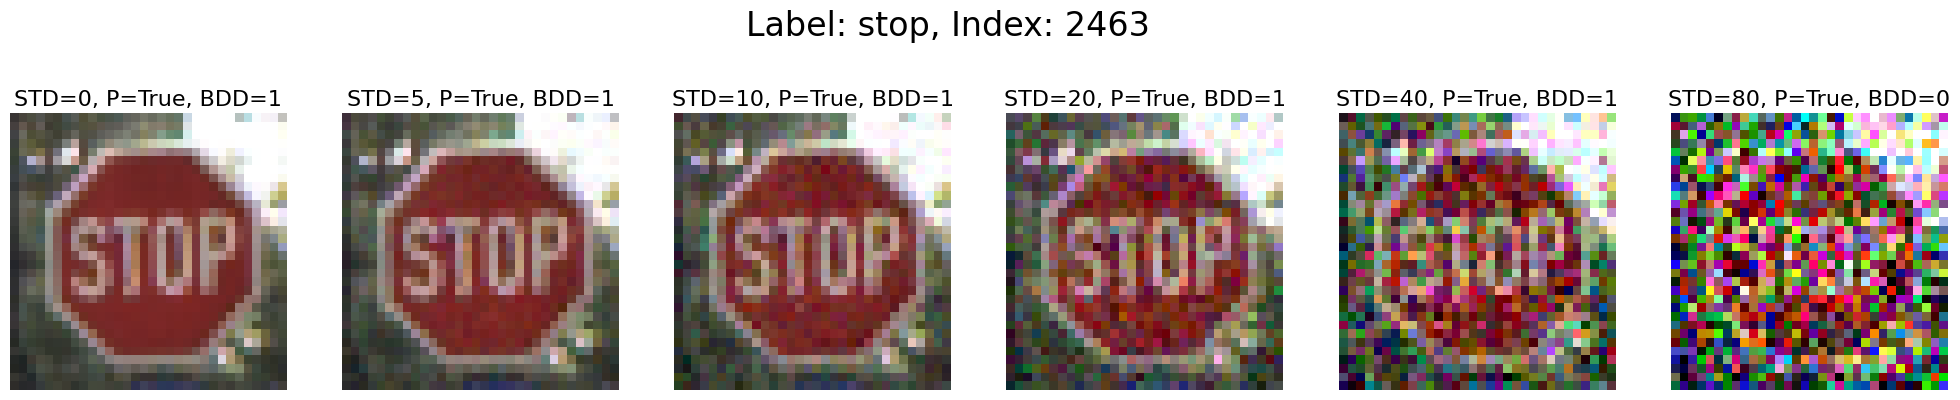

In [146]:
show_image(45)

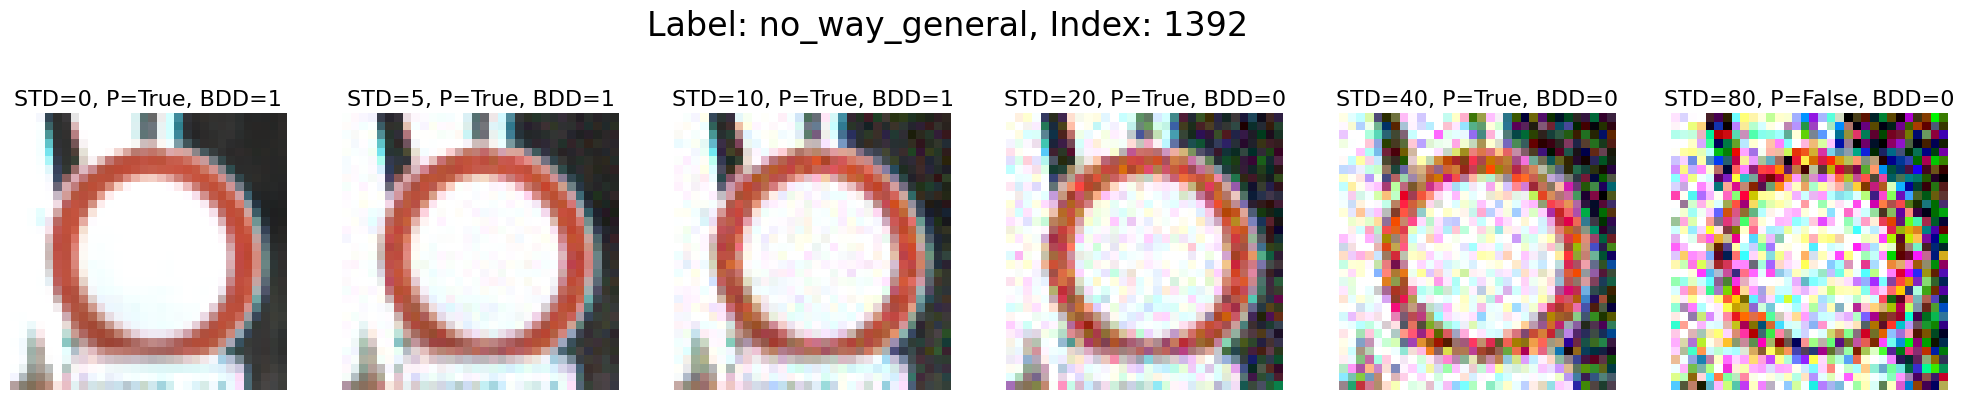

In [147]:
show_image(99)

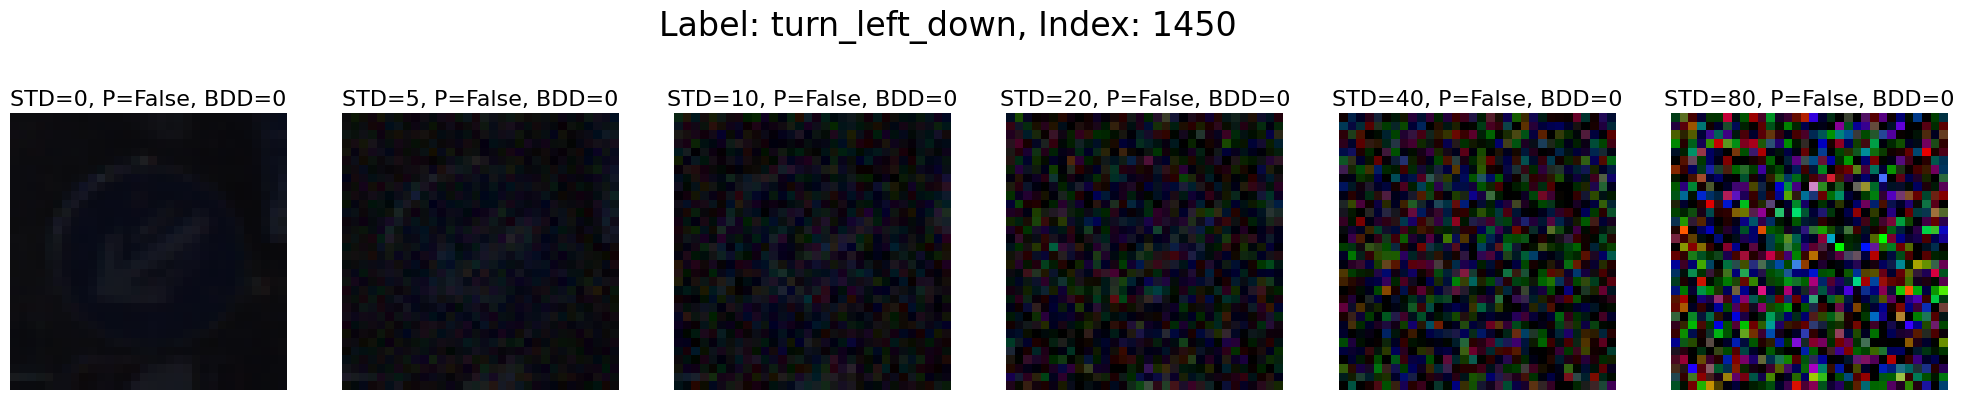

In [149]:
show_image(misclassified[0])

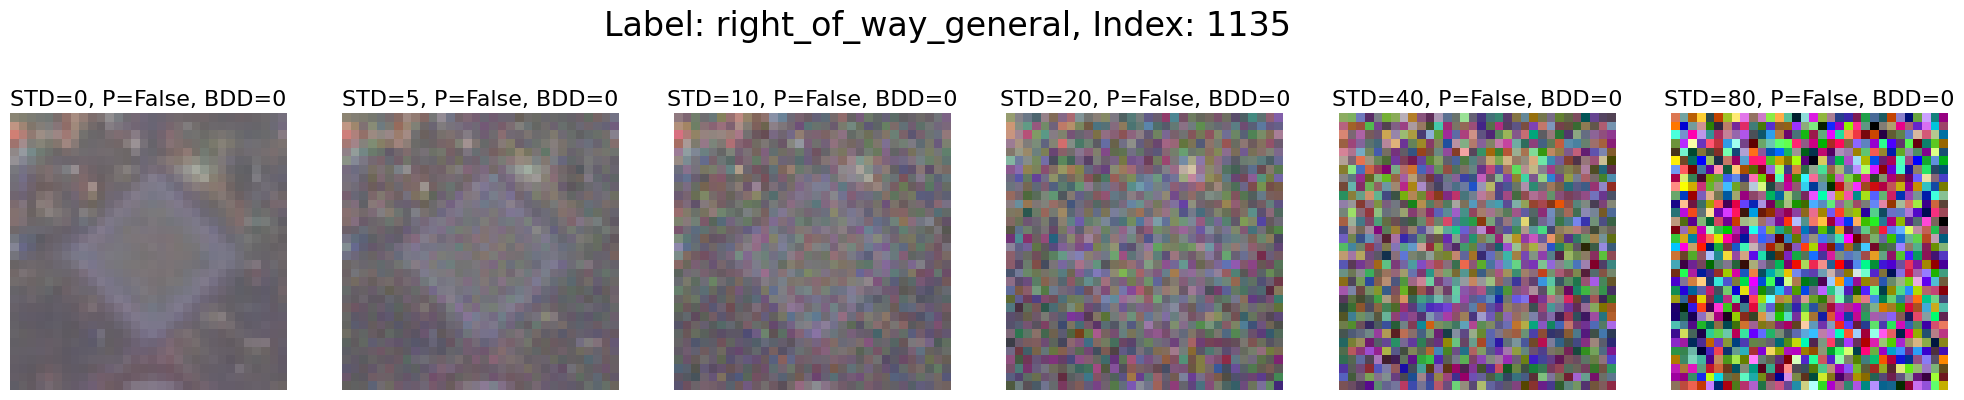

In [150]:
show_image(misclassified[2])

# Data Augmentation

In [283]:
def show_image(id_):
    plt.close('all')

    if DATASET == "GTSRB":
        im = torch.tensor(plt.imread(test_data.root / test_data.data[1][idx[id_]])).permute(2, 0, 1)
    else:
        im = test_data[idx[id_]][0]

    augs = {
        "Original":lambda x: x,
        "Rotation":T.RandomRotation((-45,45)),
        "Crop":T.RandomCrop((32,32)),
        "VerticalFlip":T.RandomVerticalFlip(p=1),
        "HorizontalFlip":T.RandomHorizontalFlip(p=1),
        "Erasing":T.RandomErasing(p=1)
    }

    test_data_aug = [t(im.type(torch.float32))/255 for t in augs.values()]
    
    x = transformer['test'].transforms[1](torch.stack(test_data_aug))

    logits, pred = model.output_last_layer(x.to(device))
    logits = logits.cpu().numpy()
    pred = pred.argmax(axis=1).cpu().numpy()
    logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])

    logits['y'] = test_data.data[0][idx[id_]]
    logits['true'] = pred == test_data.data[0][idx[id_]]

    logits_copy = logits.copy()
    patterns.evaluate_dataframe(logits_copy, 0)

    fig, ax = plt.subplots(1, len(augs), figsize=(len(augs)*5, 5))

    for i,(k,m,a) in enumerate(zip(augs.keys(),test_data_aug, ax)):
        a.imshow(m.permute(1, 2, 0))
        a.set_title(f"Aug={k}\nP={logits_copy['true'][i]}, BDD={logits_copy['bdd_0'][i]}", fontsize=16)
        a.axis(False)

    fig.suptitle(f"Label: {feature_names[test_data.data[0][idx[id_]]]}, Index: {idx[id_]}", fontsize=24, y=1.01)
    plt.show()

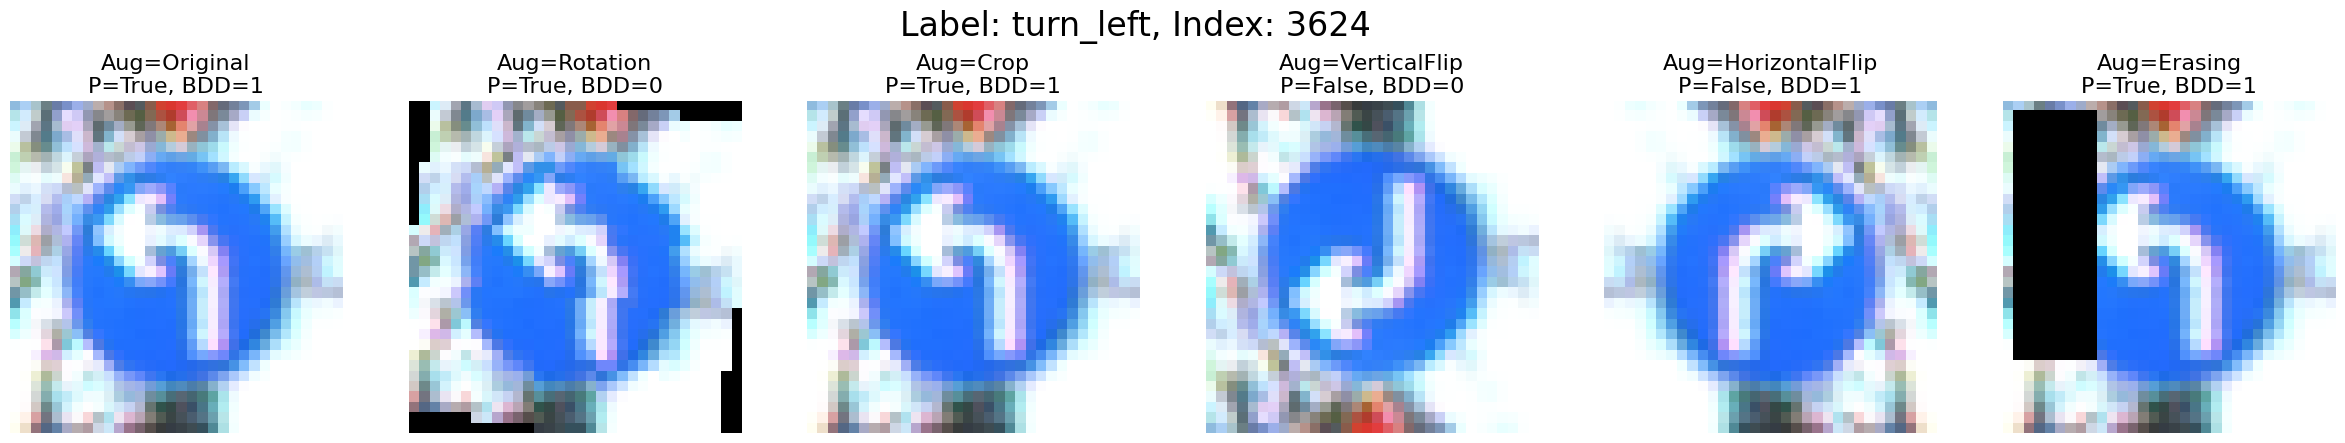

In [287]:
show_image(3)

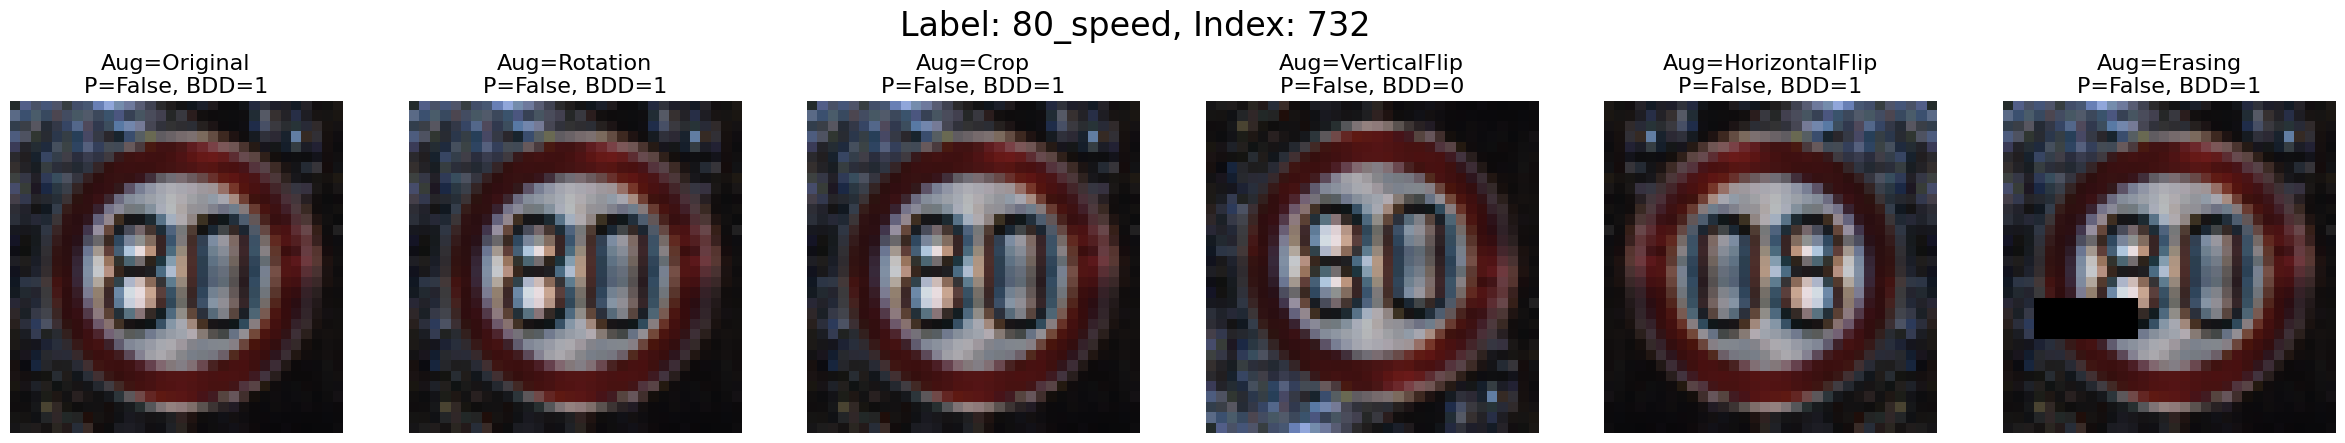

In [285]:
show_image(36)

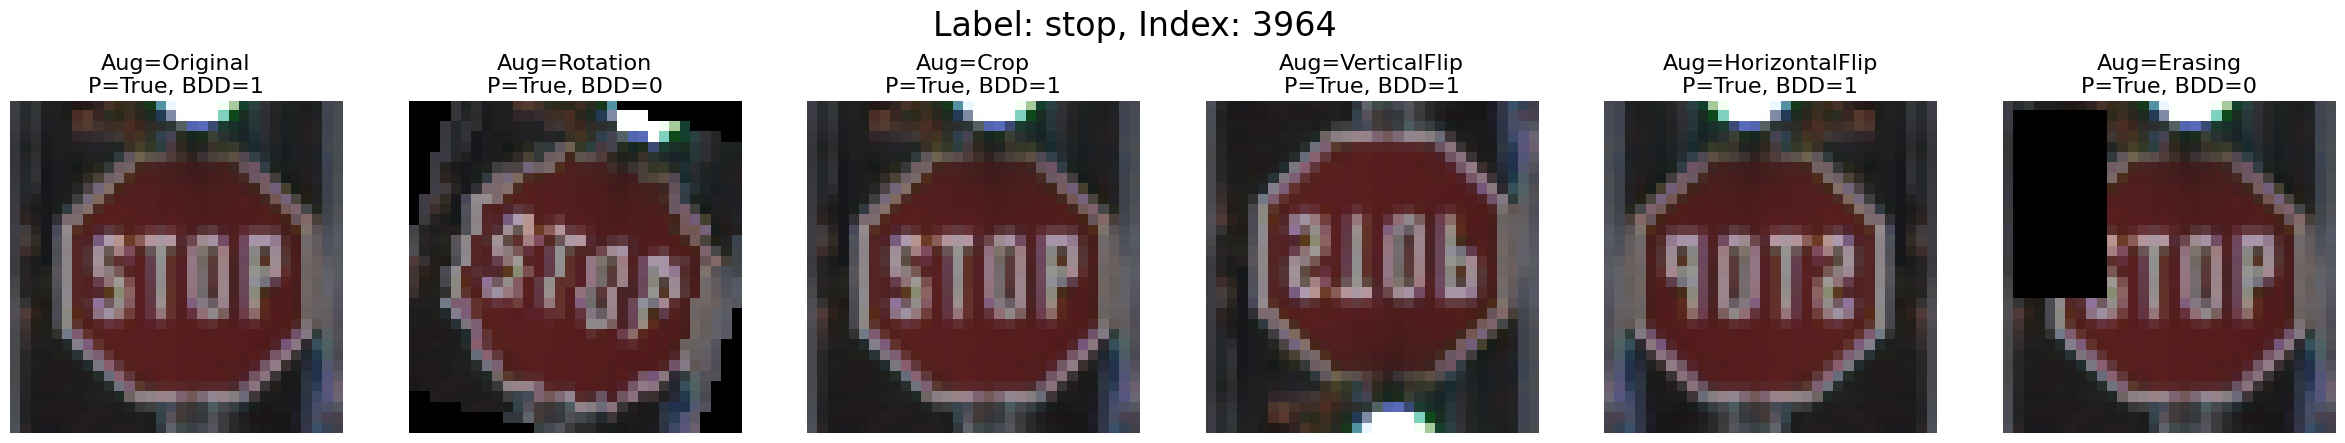

In [273]:
show_image(103)